In [3]:
import netCDF4 as nc

u_250 = nc.Dataset('u_f_flux_true_250m_100yrs.nc')
u_500 = nc.Dataset('u_f_flux_true_500m_100yrs.nc')

print(u_250.variables.keys())

print("U_250 Data Shape")
print(u_250['u'].shape)
print(u_250['f'].shape)
print(u_250['flux'].shape)

print("U_500 Data Shape")
print(u_500['u'].shape)
print(u_500['f'].shape)
print(u_500['flux'].shape)



dict_keys(['u', 'f', 'flux'])
U_250 Data Shape
(72001, 73)
(72001, 73)
(72001, 73)
U_500 Data Shape
(72001, 37)
(72001, 37)
(72001, 37)


# Prepare data

In [4]:
# Set U_250 as the data
data = u_250
# Remove the last row and column from u
u = data['u'][:-1, 1:-1]
# Remove the first row and column from f
f = data['f'][1:, 1:-1]


In [21]:
input_mean = u.mean()
input_std = u.std()
output_mean = f.mean()
output_std = f.std()

print("Input Mean: ", input_mean)
print("Input Std: ", input_std)
print("Output Mean: ", output_mean)
print("Output Std: ", output_std)

Input Mean:  0.02826505
Input Std:  19.371218
Output Mean:  9.379327e-09
Output Std:  3.0966285e-06


# Create Torch Dataset

In [17]:
import torch

# Set the random seed for reproducibility
torch.manual_seed(0)

# Set the device to be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create a torch dataset
class FNOData(torch.utils.data.Dataset):
    def __init__(self, u, f):
        super(FNOData, self).__init__()
        self.u = u
        self.f = f
        self.len = u.shape[0]

    def __getitem__(self, index):
        return self.u[index], self.f[index]

    def __len__(self):
        return self.len

dataset = FNOData(u, f)

# Split the dataset into train and validation sets (not randomly)
# Calculate sizes
validation_ratio = 0.1  # 10% validation
train_ratio = 0.8  # 80% training

train_size = int(train_ratio * len(dataset))
validation_size = int(validation_ratio * len(dataset))
test_size = len(dataset) - train_size - validation_size

# Create subsets
train_dataset = FNOData(u[:train_size], f[:train_size])
validation_dataset = FNOData(u[train_size:train_size + validation_size], f[train_size:train_size + validation_size])
test_dataset = FNOData(u[train_size + validation_size:], f[train_size + validation_size:])

print(u[:train_size].mean())
print(u[:train_size].std())
print(f[:train_size].mean())
print(f[:train_size].std())

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(validation_dataset))
print("Test dataset size:", len(test_dataset))


# train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
# validation_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + validation_size))
# test_dataset = torch.utils.data.Subset(dataset, range(train_size + validation_size, len(dataset)))

# Create a dataloader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=50, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True)


0.07815116
19.41376
1.021492e-08
3.0938054e-06
Train dataset size: 57600
Validation dataset size: 7200
Test dataset size: 7200


# Model

## Import Libraries

In [5]:
import numpy as np
import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import sys
import netCDF4 as nc
#from prettytable import PrettyTable
from count_parameters import count_parameters
import hdf5storage
import pickle

1.13.0


## Notes to remember from training 

In [6]:
input_size = 512
output_size = 512
hidden_layer_size = 1000

# Defining Integrator

In [7]:
def RK4step(net,input_batch):
 output_1 = net(input_batch.cuda())
 output_2 = net(input_batch.cuda()+0.5*output_1)
 output_3 = net(input_batch.cuda()+0.5*output_2)
 output_4 = net(input_batch.cuda()+output_3)

 return input_batch.cuda() + time_step*(output_1+2*output_2+2*output_3+output_4)/6


def Eulerstep(net,input_batch):
 output_1 = net(input_batch.cuda())
 return input_batch.cuda() + time_step*(output_1) 
  

def directstep(net,input_batch):
  output_1 = net(input_batch.cuda())
  return output_1

# FNO architecture

In [8]:
################################################################
#  1d Fourier Integral Operator
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(SpectralConv1d, self).__init__()
        """
        Initializes the 1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        Args:
            in_channels (int): input channels to the FNO layer
            out_channels (int): output channels of the FNO layer
            modes (int): number of Fourier modes to multiply, at most floor(N/2) + 1
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = (1 / (in_channels*out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        """
        Complex multiplication of the Fourier modes.
        [batch, in_channels, x], [in_channel, out_channels, x] -> [batch, out_channels, x]
            Args:
                input (torch.Tensor): input tensor of size [batch, in_channels, x]
                weights (torch.Tensor): weight tensor of size [in_channels, out_channels, x]
            Returns:
                torch.Tensor: output tensor with shape [batch, out_channels, x]
        """
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fourier transformation, multiplication of relevant Fourier modes, backtransformation
        Args:
            x (torch.Tensor): input to forward pass os shape [batch, in_channels, x]
        Returns:
            torch.Tensor: output of size [batch, out_channels, x]
        """
        batchsize = x.shape[0]
        # Fourier transformation
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    pass
class FNO1d(nn.Module):
    def __init__(self, modes, width, time_future, time_history):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: a driving function observed at T timesteps + 1 locations (u(1, x), ..., u(T, x),  x).
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """
        self.modes = modes
        self.width = width
        self.time_future = time_future
        self.time_history = time_history
        self.fc0 = nn.Linear(self.time_history+1, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.time_future)

    def forward(self, u):
        grid = self.get_grid(u.shape, u.device)
        print(grid.shape)
        x = torch.cat((u, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)


# Model Parameter

In [9]:
time_history = 1 #time steps to be considered as input to the solver
time_future = 1 #time steps to be considered as output of the solver
device = 'cuda'  #change to cpu of no cuda available

#Model parameters
modes = 256 # number of Fourier modes to multiply
width = 1 # input and output channels to the FNO layer

num_epochs = 2 #set to one so faster computation, in principle 20 is best
learning_rate = 0.0001
lr_decay = 0.4
num_workers = 0

mynet = FNO1d(modes, width, time_future, time_history).cuda()
count_parameters(mynet)
mynet.cuda()
epochs = 60

loss = nn.MSELoss()
#use two optimizers.  learing rates seem to work.

optimizer = optim.AdamW(mynet.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0, 5, 10, 15], gamma=lr_decay)

batch_size=100

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|   fc0.weight  |     2      |
|    fc0.bias   |     1      |
| conv0.weights |    256     |
| conv1.weights |    256     |
| conv2.weights |    256     |
| conv3.weights |    256     |
|   w0.weight   |     1      |
|    w0.bias    |     1      |
|   w1.weight   |     1      |
|    w1.bias    |     1      |
|   w2.weight   |     1      |
|    w2.bias    |     1      |
|   w3.weight   |     1      |
|    w3.bias    |     1      |
|   fc1.weight  |    128     |
|    fc1.bias   |    128     |
|   fc2.weight  |    128     |
|    fc2.bias   |     1      |
+---------------+------------+
Total Trainable Params: 1,420


## Training Loop

In [10]:
for epoch in range(num_epochs):
    
    # Training Data Loop
    for i, data_train in enumerate(train_dataloader):
        inputs_train, labels_train = data_train[0], data_train[1]
        
        # Move tensors to the configured device
        inputs_train = inputs_train.to(device=device, dtype = torch.float32)
        labels_train = labels_train.to(device=device, dtype = torch.float32)

        # Forward pass train
        model_output = directstep(mynet,inputs_train)
        train_loss = loss(model_output,labels_train)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward(retrain_graph=True)
        optimizer.step()    
    del inputs_train, labels_train, model_output
    
    # Test Data Loop
    for i, data_test in enumerate(test_dataloader):
        inputs_test, labels_test = data_test[0], data_test[1]

        # Move tensors to the configured device
        inputs_test = inputs_test.to(device=device, dtype = torch.float32)
        labels_test = labels_test.to(device=device, dtype = torch.float32)

        # Forward pass test
        model_output_test = directstep(mynet, inputs_test)
        test_loss = loss(model_output_test, labels_test)
        
        # Check if the model is improving
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(mynet.state_dict(), 'best_model.pt')
    
            
    del inputs_test, labels_test, model_output_test
    # Print the progress in files
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            .format(epoch+1, num_epochs, i+1, len(train_dataloader), train_loss.item()))
            
    
# Save the model checkpoint
torch.save(mynet.state_dict(), 'model.pt')

torch.Size([50, 71, 1])


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [ ]:
M=20000
pred = np.zeros([M,np.size(label_test,1)])
for k in range(0,M):
 
    if (k==0):

        out = RK4step(mynet,torch.reshape(input_test_torch[0,:],(1,input_size,1)))
        pred [k,:] = torch.reshape(out,(1,input_size)).detach().cpu().numpy()

    else:

        out = RK4step(mynet,torch.reshape(torch.from_numpy(pred[k-1,:]),(1,input_size,1)).float().cuda())

        pred [k,:] = torch.reshape(out,(1,input_size)).detach().cpu().numpy()

matfiledata = {}
matfiledata[u'prediction'] = pred
matfiledata[u'Truth'] = label_test 
hdf5storage.write(matfiledata, '.', path_outputs+'predicted_FNO_KS_RK4step_lead'+str(lead)+'.mat', matlab_compatible=True)

print('Saved Predictions')

        

dict_keys(['pred_val', 'true_val'])
(7200, 71)
(7200, 71)


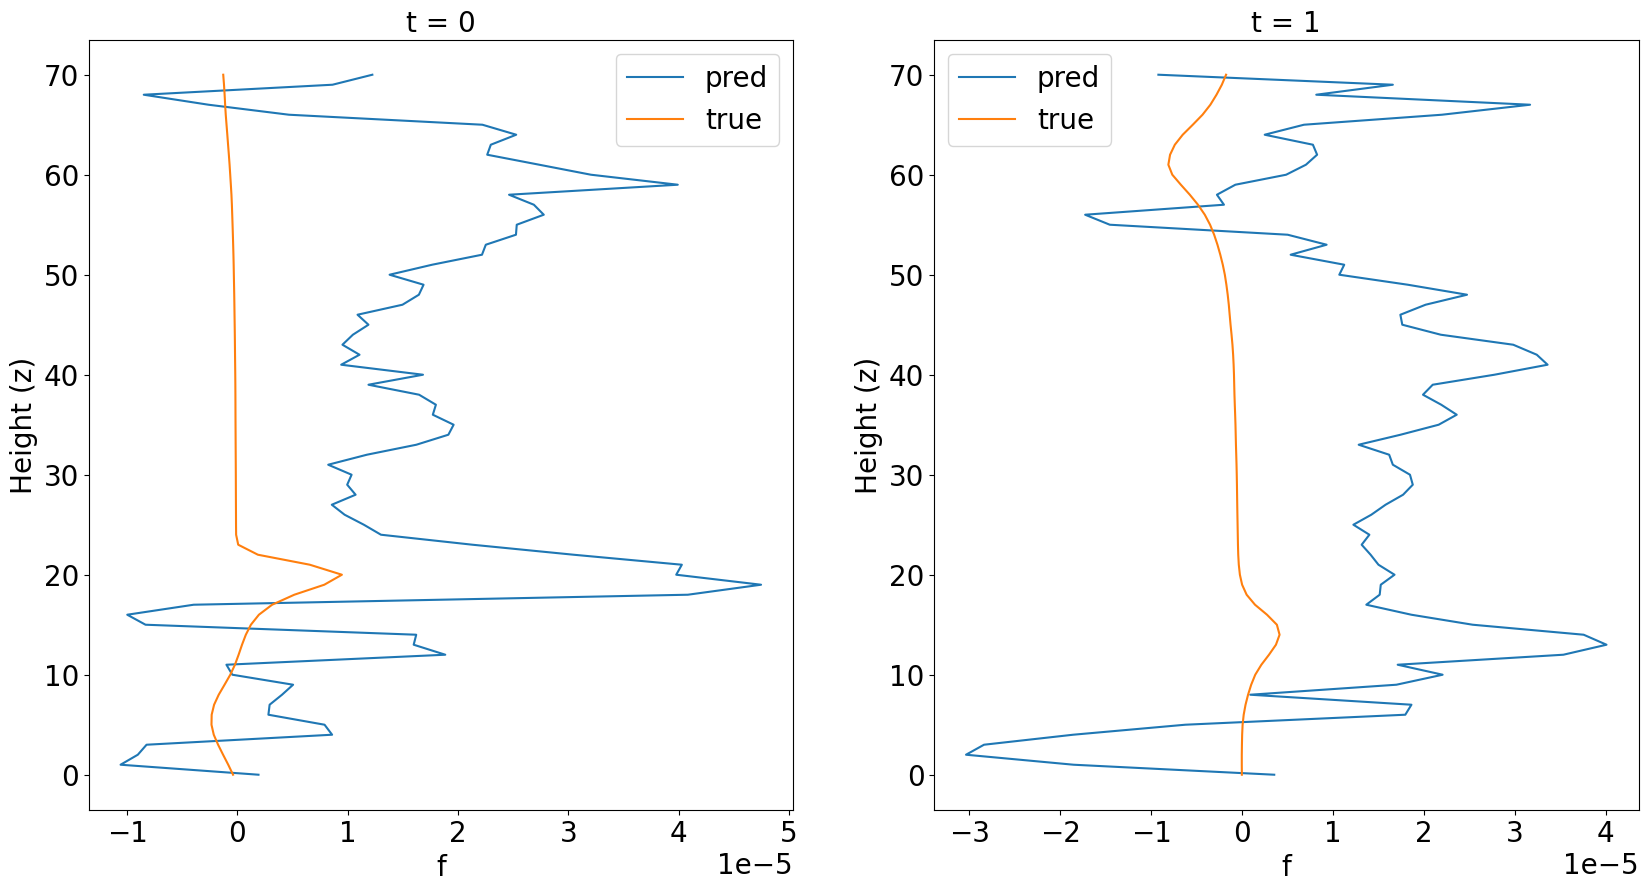

[-4.6244822e-06  1.0697637e-05  1.3016630e-05  2.6151072e-05
  2.2704713e-05  1.9425526e-05  2.2685155e-05  2.5743153e-05
  2.5953166e-05  2.6109628e-05  3.0251686e-05  3.6970247e-05
  4.2115338e-05  5.1710755e-05  5.4107513e-05  4.8588496e-05
  3.8910192e-05  2.9422343e-05  2.7856790e-05  1.9606669e-05
  2.2807159e-05  1.4395453e-05  1.8968247e-05  3.8711820e-05
  2.1623913e-05  2.9114075e-05  3.6037061e-05  8.8019297e-06
  2.5459100e-05  5.0703529e-05  3.1652860e-05  1.1273194e-05
  3.8980506e-06  3.5879202e-06  7.1590766e-06  5.3532422e-06
  3.3467077e-06 -3.7765130e-07 -1.7588027e-06  1.7071143e-06
  6.5518543e-07  1.3774261e-06 -4.7963113e-07 -1.8095598e-06
  4.0279701e-06  5.2493997e-06  9.3728304e-06  1.2516044e-05
  1.0634307e-05  1.8573366e-05  2.0342879e-05  2.1989923e-05
  2.1282118e-05  2.2633933e-05  2.1473039e-05  2.7579255e-05
  3.3066142e-05  3.5067089e-05  3.5888050e-05  3.4984201e-05
  3.4981407e-05  4.0356535e-05  3.6840327e-05  3.3031218e-05
  3.0357391e-05  2.78875

In [28]:

# 
from netCDF4 import Dataset
data = Dataset('pred_true_val.nc', 'r')
print(data.variables.keys())
pred = data.variables['pred_val'][:]
true = data.variables['true_val'][:]

print(pred.shape)
print(true.shape)

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.titlesize'] = 20

time1 = 240
time2 = 480
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
# Plot pred and true together 
ax1.plot(pred[time1, :],range(pred.shape[1]), label='pred')
ax1.plot(true[time1, :],range(true.shape[1]), label='true')
ax1.legend()
ax1.set_title('t = 0')
ax1.set_xlabel('f')
ax1.set_ylabel('Height (z)')

ax2.plot(pred[time2, :],range(pred.shape[1]), label='pred')
ax2.plot(true[time2, :],range(true.shape[1]), label='true')
ax2.legend()
ax2.set_title('t = 1')
ax2.set_xlabel('f')
ax2.set_ylabel('Height (z)')
plt.show()

# close the file
data.close()

print(pred[0,:])
